# Folic Acid Effective Coverage MINIMOD Simulations

-  This uses Folate Eff. Coverage and 6-59 mos. children population data

In [1]:
import pandas as pd
import geopandas as gpd
import minimod
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact, IntSlider

data_folder = 'optimization_work/demewoz_lives_saved/data_files/'

effective_coverage_folder = data_folder + 'effective_coverage/'
cost_folder = data_folder + 'new_cost_benefits/'

In [2]:
# First load in cost data
costs_raw = pd.read_excel(cost_folder + 'lives_saved_costs.xlsx', sheet_name='costs')

# Load in fflour33 cost data
fflour33_costs = (
    pd.read_excel(effective_coverage_folder + 'flour fortification 2019data 2019USD Folate 33% (1).xlsx', sheet_name = 'Flour cost calculation 10y ', header = 25)
    .drop(columns = ['Unnamed: 0', 'Unnamed: 1', 'Total'])
    .assign(intervention = 'fflour33')
    .rename({year: num + 1 for year, num in zip(range(2020, 2030,1), range(10))}, axis=1)
    .rename({'Region' : 'region'}, axis=1)
    .set_index(['intervention', 'region'])
    .drop(['National'], level='region')
    .reset_index()
    )

# append fflour33 costs with cost data
costs = (
    costs_raw
    .set_index('intervention')
    .drop('fflour33', axis=0)
    .reset_index()
    .append(fflour33_costs, ignore_index=True)
    )

# Get intervention names to change
folate_eff_cov = (
pd.read_excel(effective_coverage_folder + 'folate_results.xlsx', sheet_name = 'Number_effective_wra_covered')
)

long_intervention_names = folate_eff_cov['note'].unique().tolist()
short_intervention_names = \
    ['fcubefflour',
    'fflour33',
    'fflour',
    'fcube'
    ]
intervention_rename_list = {k:v for k,v in zip(long_intervention_names, short_intervention_names)}


In [3]:
df_benefits_mean = (
folate_eff_cov
.loc[lambda df: df['zoneName']!='Overall']
.assign(intervention = lambda df: df['note'].replace(intervention_rename_list))
.rename({'zoneName' : 'region'}, axis=1)
.drop(columns = ['nutrient','note', 'zone', 'Assumptions'])
.set_index(['intervention', 'region'])
.rename({year: str(num + 1) for year, num in zip(range(2020, 2030,1), range(10))}, axis=1)
.drop(columns = range(2030,2036,1))
.stack()
.reset_index()
.rename({'level_2' : 'time',
0 : 'eff_cov_mean'}, axis=1)
.assign(time = lambda df: df['time'].astype(int))
)
df_benefits_mean


,intervention,region,time,eff_cov_mean
0,fcubefflour,Cities,1,0.000000e+00
1,fcubefflour,Cities,2,0.000000e+00
2,fcubefflour,Cities,3,1.175607e+06
3,fcubefflour,Cities,4,1.295187e+06
4,fcubefflour,Cities,5,1.337125e+06
...,...,...,...,...
115,fcube,South,6,1.917019e+06
116,fcube,South,7,1.954145e+06
117,fcube,South,8,1.991287e+06
118,fcube,South,9,2.027066e+06


In [4]:
# Create costs
df_costs = (
costs
.set_index(['intervention', 'region'])
.stack()
.reset_index()
.rename({'level_2' : 'time', 0 : 'costs'}, axis=1)
)

In [5]:
# Create function to make data adjustments
def observation_adjustment(data, int1, int2, time_to_replace, space_to_replace = slice(None)):
    
    df = data.copy(deep = True)

    if isinstance(int2, str):
        df_int2 = df.loc[(int2, space_to_replace, time_to_replace)]
        df.loc[(int1, space_to_replace, time_to_replace), :] = df_int2.values
    elif int2 == 0:
        df.loc[(int1, space_to_replace, time_to_replace), :] = 0

    print(f"Changed {int1} to {int2}")

    return df

In [6]:
df_benefits_adjusted = (df_benefits_mean.set_index(['intervention', 'region', 'time'])
.pipe(observation_adjustment,
int1 = "fcube",
int2 = 0,
time_to_replace = [1,2,3])
.pipe(observation_adjustment,
int1 = "fflour",
int2 = 'fflour33',
time_to_replace = [1,2,3])
)

Changed fcube to 0
Changed fflour to fflour33


In [7]:
df_adjusted = df_benefits_adjusted.merge(df_costs, on = ['intervention', 'region', 'time'], how= 'left', indicator=True)


In [8]:
df_adjusted._merge.value_counts()
df_adjusted = df_adjusted.drop(columns = ['_merge'])

## Summary Tables

In [9]:

s = minimod.utils.summary.PreOptimizationDataSummary(
    data = df_adjusted.reset_index(),
    benefit_col= 'eff_cov_mean',
    cost_col= 'costs',
    intervention_col='intervention',
    space_col= 'region',
    time_col='time',
    benefit_title='WRA Effectively Covered (Folate)',
    intervention_subset=['fflour', 'fcube', 'fcubefflour'],
    intervention_subset_titles={'fflour' : 'Flour with Folic Acid (100%)',
    'fcube' : 'Cube with Folic Acid (100%)',
    'fcubefflour' : 'Flour + Cube with Folic Acid',
    'fflour33' : 'BAU: Folic Acid Flour (33%)'},
    bau_intervention = 'fflour33'
)

s.summary_table(variables_of_interest= {'Cost per WRA ($)' : 'cost_per_benefit'}, grouping = 'over_space', style = 'markdown')


,Intervention,Regions,WRA Effectively Covered (Folate),Costs ($),Cost per WRA ($)
8,Flour with Folic Acid (100%),Cities,"10,318,540","1,828,717",0.180000
10,Flour with Folic Acid (100%),North,"4,948,759","1,106,138",0.220000
11,Flour with Folic Acid (100%),South,"9,648,620","1,749,202",0.180000
9,Flour with Folic Acid (100%),National,"24,915,919","4,684,057",0.190000
0,Cube with Folic Acid (100%),Cities,"9,401,915","770,962",0.080000
2,Cube with Folic Acid (100%),North,"7,482,600","1,210,795",0.160000
3,Cube with Folic Acid (100%),South,"13,678,779","1,332,092",0.100000
1,Cube with Folic Acid (100%),National,"30,563,294","3,313,850",0.110000
4,Flour + Cube with Folic Acid,Cities,"11,187,961","2,599,679",0.230000
6,Flour + Cube with Folic Acid,North,"8,226,111","2,316,933",0.280000


In [10]:
m = minimod.Minimod(solver_type = 'costmin',
data = df_adjusted,
benefit_col = 'eff_cov_mean',
cost_col = 'costs',
space_col = 'region',
all_space = ['fcube', 'fflour'],
all_time = ['fcube', 'fflour'],
time_subset = [1,2,3],
benefit_title = 'WRA Effectively Covered (Folate)',
minimum_benefit = 'fflour33',
)

[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.6dev
                Solver: CBC,
                Show Output: True
                
                


In [11]:
m.fit()

[Note]: Optimizing...
[Note]: Optimal Solution Found


In [12]:
m.report()

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+------+
| No. of Variables:           |  120 |
| No. of Integer Variables:   |  120 |
| No. of Constraints          |  313 |
| No. of Non-zeros in Constr. | 1623 |
+-----------------------------+------+
Interventions Chosen:
+----------------------------------------+-------------+
| Minimum Benefit                        | 1.45004e+07 |
| Objective Bounds                       | 1.55095e+06 |
| Total Cost                             | 1.55095e+06 |
| Total WRA Effectively Covered (Folate) | 1.45004e+07 |
+--------------------------------------

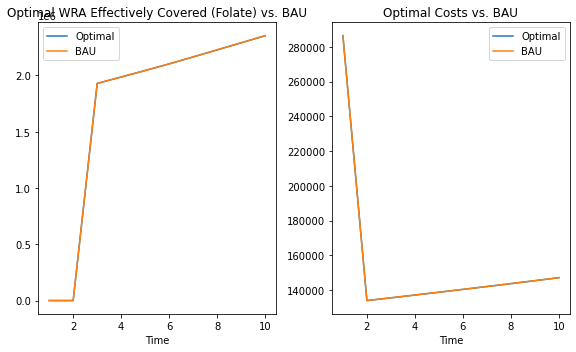

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize = (8,5))
m.plot_bau_time(ax=ax1)
m.plot_bau_time(opt_variable = 'c', ax=ax2)
plt.savefig("low_bau.png", dpi=600)

In [14]:
# Load data
geo_df = gpd.read_file("examples/data/maps/cameroon/CAM.shp")

# Now we create the boundaries for North, South and Cities
# Based on "Measuring Costs of Vitamin A..., Table 2"
north = r"Adamaoua|Nord|Extreme-Nord"
south = r"Centre|Est|Nord-Ouest|Ouest|Sud|Sud-Ouest"
cities= r"Littoral" # Duala
# Yaounde is in Mfoundi
geo_df.loc[lambda df: df['ADM1'].str.contains(north), 'space'] = 'North'
geo_df.loc[lambda df: df['ADM1'].str.contains(south), 'space'] = 'South'
geo_df.loc[lambda df: df['ADM1'].str.contains(cities), 'space'] = 'Cities'
geo_df.loc[lambda df: df['ADM2'].str.contains(r"Mfoundi"), 'space'] = 'Cities'

# Now we aggregate the data to the `space` variable
agg_geo_df = geo_df.dissolve(by = 'space')


In [25]:
interact(m.plot_map_benchmark, 
intervention = fixed(None), 
time = IntSlider(min=1, max=10, step=1, value=1), 
optimum_interest = ['b', 'c', 'cdb', 'cdc', 'cb', 'cc'], 
bench_intervention = fixed('fflour33'),
map_df = fixed(agg_geo_df),
merge_key = fixed('space'),
intervention_in_title = fixed(True),
intervention_bubbles= fixed(True),
intervention_bubble_names = fixed(['fflour33']),
bau_intervention_bubble_names = fixed(['fflour33']),
save = fixed(None))

interactive(children=(IntSlider(value=1, description='time', max=10, min=1), Dropdown(description='optimum_int…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### Different Constraint Reports

In [16]:
models = {}

for opt_type in [None, 'time', 'space', 'both']:

    print(f"Running with {opt_type}")

    m = minimod.Minimod(solver_type = 'costmin',
    data = df_adjusted,
    benefit_col = 'eff_cov_mean',
    cost_col = 'costs',
    space_col = 'region',
    all_space = ['fcube', 'fflour'],
    all_time = ['fcube', 'fflour'],
    time_subset = [1,2,3],
    benefit_title = 'WRA Effectively Covered (Folate)',
    minimum_benefit = 'fflour33',
    main_constraint_over = opt_type)

    try:
        models[opt_type] = m.fit()
    except Exception:
        continue

Running with None
[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.6dev
                Solver: CBC,
                Show Output: True
                
                
[Note]: Optimizing...
[Note]: Optimal Solution Found
Running with time
[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.6dev
                Solver: CBC,
                Show Output: True
                
                
[Note]: Optimizing...
[Note]: Optimal Solution Found
Running with space
[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.6dev
                Solver: CBC,
                

### Reports

In [17]:
def report_model(m):

    return getattr(m, 'report')()

In [18]:
interact(report_model, 
m= models)

interactive(children=(Dropdown(description='m', options={None: <minimod.solvers.costsolver.CostSolver object a…

<function __main__.report_model(m)>

### BAU Plots

In [19]:
def plot_bau_model(m):

    fig, (ax1, ax2) = plt.subplots(1,2,  figsize = (8,5))
    getattr(m, 'plot_bau_time')(ax=ax1)
    getattr(m, 'plot_bau_time')(opt_variable = 'c', ax=ax2)

In [20]:
interact(plot_bau_model, 
m= models)

interactive(children=(Dropdown(description='m', options={None: <minimod.solvers.costsolver.CostSolver object a…

<function __main__.plot_bau_model(m)>

### Maps

In [21]:
def plot_map_model(m, **kwargs):

    return getattr(m, 'plot_map_benchmark')(**kwargs)

In [22]:
interact(plot_map_model,
m= models,
intervention = fixed(None), 
time = IntSlider(min=1, max=10, step=1, value=1), 
optimum_interest = ['b', 'c', 'cdb', 'cdc', 'cb', 'cc'], 
bench_intervention = fixed('fflour33'),
map_df = fixed(agg_geo_df),
merge_key = fixed('space'),
intervention_in_title = fixed(True),
intervention_bubbles= fixed(True),
intervention_bubble_names = fixed(['fflour33']),
bau_intervention_bubble_names = fixed(['fflour33']),
save = fixed(None))

interactive(children=(Dropdown(description='m', options={None: <minimod.solvers.costsolver.CostSolver object a…

<function __main__.plot_map_model(m, **kwargs)>

In [23]:
intervention_rename_list

{'Folate WF fortification (5 µg/d) cube fortification(100 µg/g)': 'fcubefflour',
 'Folate WF fortification(1.65 ug/g)': 'fflour33',
 'Folate WF fortification(5.0 µg/g)': 'fflour',
 'Folate cube fortification(100 µg/g)': 'fcube'}